In [94]:
from matplotlib import pyplot as plt
# import warnings
# warnings.filterwarnings('ignore')
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns

Projekt zaliczeniowy PSI- Piotr Kubacki Temat: Przewidywanie zawału na podstawie danych medycznych

In [95]:
data = pd.read_csv("healthcare-dataset-stroke-data.csv")
# del data['id']
data.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


1) id: unique identifier
2) gender: "Male", "Female" or "Other"
3) age: age of the patient
4) hypertension: 0 if the patient doesn't have hypertension, 1 if the patient has hypertension
5) heart_disease: 0 if the patient doesn't have any heart diseases, 1 if the patient has a heart disease
6) ever_married: "No" or "Yes"
7) work_type: "children", "Govt_jov", "Never_worked", "Private" or "Self-employed"
8) Residence_type: "Rural" or "Urban"
9) avg_glucose_level: average glucose level in blood
10) bmi: body mass index
11) smoking_status: "formerly smoked", "never smoked", "smokes" or "Unknown"*
12) stroke: 1 if the patient had a stroke or 0 if not
*Note: "Unknown" in smoking_status means that the information is unavailable for this patient

Sprawdźmy unikalne wartości w kolumnach kategorycznych

In [96]:
for col in (data['gender'],data['ever_married'],data['work_type'],data['Residence_type'],data['smoking_status']):
    print(col.unique())

['Male' 'Female' 'Other']
['Yes' 'No']
['Private' 'Self-employed' 'Govt_job' 'children' 'Never_worked']
['Urban' 'Rural']
['formerly smoked' 'never smoked' 'smokes' 'Unknown']


In [97]:
data['smoking_status'].replace('Unknown',np.nan, inplace=True)

Zwizualizujemy brakujące dane

In [98]:
def missingdata(data):
    total = data.isnull().sum().sort_values(ascending = False)
    percent = (data.isnull().sum()/data.isnull().count()*100).sort_values(ascending = False)
    ms=pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    ms= ms[ms["Percent"] > 0]
    f,ax =plt.subplots(figsize=(8,6))
    plt.xticks(rotation='90')
    fig=sns.barplot(ms.index, ms["Percent"],color="green",alpha=0.8)
    plt.xlabel('Features', fontsize=15)
    plt.ylabel('Percent of missing values', fontsize=15)
    plt.title('Percent missing data by feature', fontsize=15)
    return ms

C:\Users\sch03\anaconda3\envs\podstawy_sztucznej_inteligencji\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


,Total,Percent
smoking_status,1544,30.215264
bmi,201,3.933464


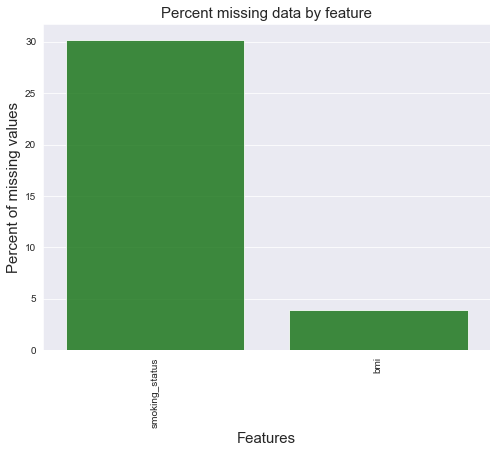

In [99]:
missingdata(data)

Trzeba coś zrobić z nanami:
* w bmi jest mało do uzupełnienia. Wrzucimy tam średnią
* smoking_status ma dużo braków, ale z uwagi na istotność kolumny uznajemy, że 30% jest akceptowalne do uzupełnienia. Za nany wrzucimy losowe wartości z ['formerly smoked' 'never smoked' 'smokes']

In [100]:
import numpy as np
filldata = ['formerly smoked', 'never smoked', 'smokes']
data['smoking_status']=data['smoking_status'].map(lambda l: l if not pd.isnull(l) else np.random.choice(filldata))

In [101]:
mean_test = data['bmi'].mean()
data['bmi'].fillna(mean_test,inplace=True)

In [102]:
data.isnull().sum()

id                   0
gender               0
age                  0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
Residence_type       0
avg_glucose_level    0
bmi                  0
smoking_status       0
stroke               0
dtype: int64

Feature engineering

In [103]:
data['age_bin'] = pd.cut(data['age'], bins=[0,12,24,54,120], labels=['Children','Teenage','Adult','Elder'])

Dzielę zgodnie z:
* https://pl.wikipedia.org/wiki/Wska%C5%BAnik_masy_cia%C5%82a
* https://www.medicalnewstoday.com/articles/a1c-chart-diabetes-numbers

In [104]:
data['avg_glucose_level_bin'] = pd.cut(data['avg_glucose_level'],bins=[0,117,137,183,250],labels=['normal','pre_diabetic','diabetic','very_diabetic'])

In [105]:
data['bmi_bin'] = 0

In [106]:
data.loc[data['age'] < 24,'bmi_bin'] = pd.cut(data['bmi'],bins=[0,19,24,29,50],labels=['underweight','optimum','overweight','obesity'])

data.loc[(34 > data['age']) &  (data['age']  >= 24),'bmi_bin'] = pd.cut(data['bmi'],bins=[0,20,25,30,50],labels=['underweight','optimum','overweight','obesity'])

data.loc[(44 > data['age']) &  (data['age'] >= 34),'bmi_bin'] = pd.cut(data['bmi'],bins=[0,21,26,31,50],labels=['underweight','optimum','overweight','obesity'])

data.loc[(54 > data['age']) &  (data['age']  >= 44),'bmi_bin'] = pd.cut(data['bmi'],bins=[0,22,27,32,50],labels=['underweight','optimum','overweight','obesity'])

data.loc[(64 > data['age']) &  (data['age']  >= 54),'bmi_bin'] = pd.cut(data['bmi'],bins=[0,23,28,33,50],labels=['underweight','optimum','overweight','obesity'])

data.loc[64 <= data['age'],'bmi_bin'] = pd.cut(data['bmi'],bins=[0,24,29,34,50],labels=['underweight','optimum','overweight','obesity'])

In [107]:
data['bmi_bin'].value_counts()

optimum        1530
overweight     1485
obesity        1358
underweight     658
Name: bmi_bin, dtype: int64

In [108]:
data['avg_glucose_level_bin'].value_counts()

normal           3931
very_diabetic     543
pre_diabetic      331
diabetic          280
Name: avg_glucose_level_bin, dtype: int64

In [109]:
data.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke,age_bin,avg_glucose_level_bin,bmi_bin
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.600000,formerly smoked,1,Elder,very_diabetic,obesity
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,28.893237,never smoked,1,Elder,very_diabetic,overweight
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.500000,never smoked,1,Elder,normal,overweight
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.400000,smokes,1,Adult,diabetic,obesity
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.000000,never smoked,1,Elder,diabetic,underweight


In [110]:
dummydf = pd.get_dummies(data.drop(columns=['id','age','bmi','avg_glucose_level']),columns=['gender','ever_married','hypertension','heart_disease','work_type','Residence_type','smoking_status','age_bin','avg_glucose_level_bin','bmi_bin'],prefix=['gender','ever_married','hypertension','heart_disease','work_type','Residence_type','smoking_status','age_type','avg_glucose_level_type','bmi_type'])

In [111]:
dummydf

,stroke,gender_Female,gender_Male,gender_Other,ever_married_No,ever_married_Yes,hypertension_0,hypertension_1,heart_disease_0,heart_disease_1,...,age_type_Adult,age_type_Elder,avg_glucose_level_type_normal,avg_glucose_level_type_pre_diabetic,avg_glucose_level_type_diabetic,avg_glucose_level_type_very_diabetic,bmi_type_obesity,bmi_type_optimum,bmi_type_overweight,bmi_type_underweight
0,1,0,1,0,0,1,1,0,0,1,...,0,1,0,0,0,1,1,0,0,0
1,1,1,0,0,0,1,1,0,1,0,...,0,1,0,0,0,1,0,0,1,0
2,1,0,1,0,0,1,1,0,0,1,...,0,1,1,0,0,0,0,0,1,0
3,1,1,0,0,0,1,1,0,1,0,...,1,0,0,0,1,0,1,0,0,0
4,1,1,0,0,0,1,0,1,1,0,...,0,1,0,0,1,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5105,0,1,0,0,0,1,0,1,1,0,...,0,1,1,0,0,0,0,1,0,0
5106,0,1,0,0,0,1,1,0,1,0,...,0,1,0,1,0,0,1,0,0,0
5107,0,1,0,0,0,1,1,0,1,0,...,1,0,1,0,0,0,0,0,1,0
5108,0,0,1,0,0,1,1,0,1,0,...,1,0,0,0,1,0,0,1,0,0


Narysujemy heatmap. Możemy dostrzec pojedyncze wartości wysokiej korelacji (niegroźne i/ lub oczywiste- np. worktype_children ~ age_children)

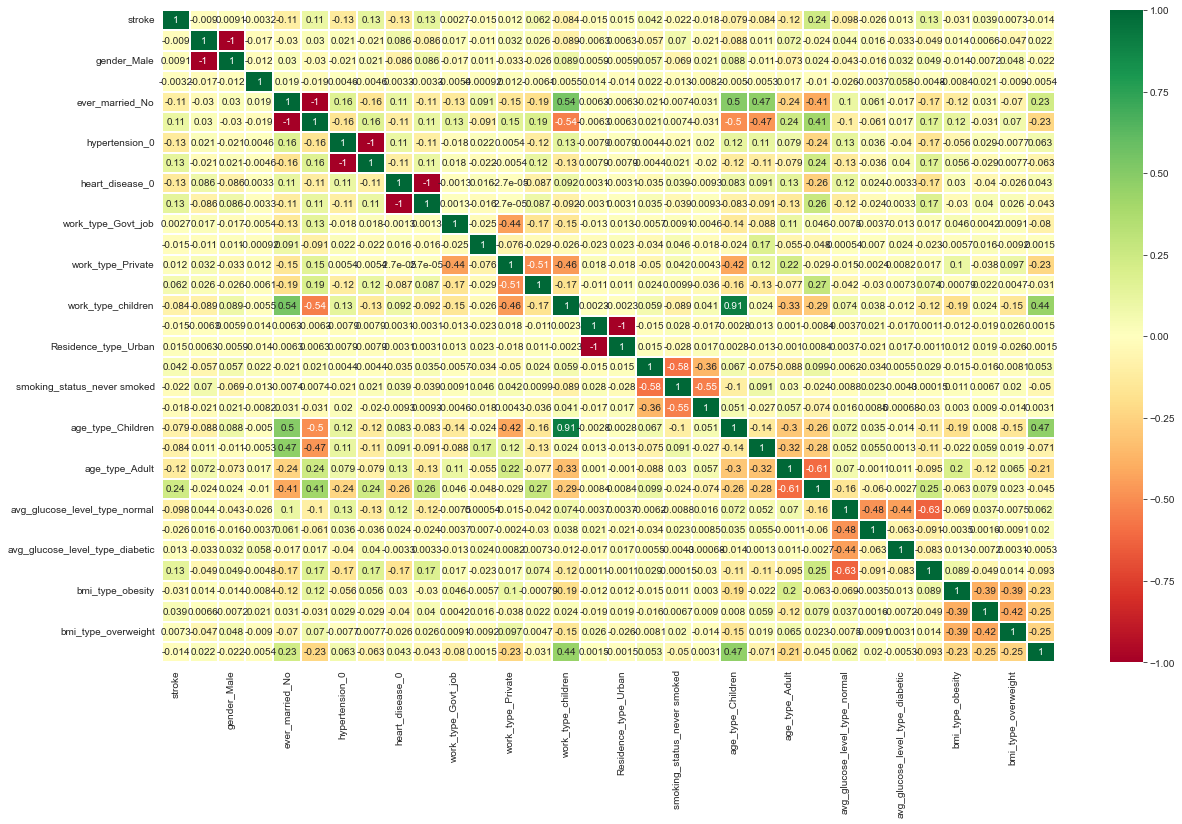

In [112]:
sns.heatmap(dummydf.corr(),annot=True,cmap='RdYlGn',linewidths=0.2)
fig=plt.gcf()
fig.set_size_inches(20,12)
plt.show()

Narysujemy pairplot

C:\Users\sch03\anaconda3\envs\podstawy_sztucznej_inteligencji\lib\site-packages\seaborn\axisgrid.py:2076: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


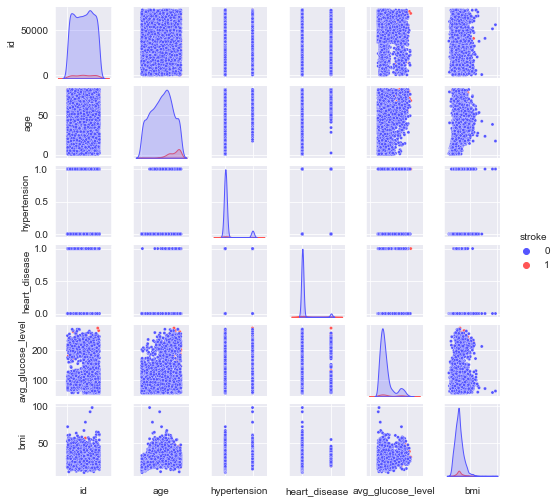

In [113]:
g = sns.pairplot(data=data, hue='stroke', palette = 'seismic',
                 size=1.2,diag_kind = 'kde',diag_kws=dict(shade=True),plot_kws=dict(s=10) )
g.set(xticklabels=[])

Modelowanie

In [114]:
from sklearn.model_selection import train_test_split #for split the data
from sklearn.metrics import accuracy_score  #for accuracy_score
from sklearn.model_selection import KFold #for K-fold cross validation
from sklearn.model_selection import cross_val_score #score evaluation
from sklearn.model_selection import cross_val_predict #prediction
from sklearn.metrics import confusion_matrix #for confusion matrix

In [115]:
all_features = dummydf.drop("stroke",axis=1)
target = dummydf['stroke']
X_train,X_test,y_train,y_test = train_test_split(all_features,target,test_size=0.3,random_state=42)
X_train.shape,X_test.shape,y_train.shape,y_test.shape

((3577, 31), (1533, 31), (3577,), (1533,))

In [ ]:
X_train

Możemy teraz podjąć się trenowania i przewidywania. Mamy wiele modeli do wyboru. Za pomocą techniki supervised learning wytrenujemy i ocenimy każdy model. Najlepsze z nich wybierzemy do gridowania.